# Setting up a DASK cluster using dask-jobqueue

This example is most relevant for GFDL users running on PP/AN. Other HPC users should adapt to match their system specifications
(e.g. batch scheduler, queue name,...). The dask_jobqueue package supports most batch schedulers.

In [1]:
# get the plot in notebook
%matplotlib inline

In [2]:
import xarray as xr

In [3]:
# import the client, this is going to be our interface to see what happens on the DASK cluster
from dask.distributed import Client

In [4]:
# SLURMCluster will allow us to submit a job to the SLURM batch scheduler
# that will run the DASK cluster
from dask_jobqueue import SLURMCluster

In [5]:
# set up a port for dashboard:
# If you want to be able to follow the progress of the dask cluster, you need
# to specify a port and create a LocalForward rule in your local machine .ss/config
# such as: LocalForward portdash localhost:portdash
import subprocess as sp
uid = int( sp.check_output('id -u', shell=True).decode('utf-8').replace('\n','') )
portdash = 10000 + uid

In [6]:
# Set up SLURM options
cluster = SLURMCluster(queue='analysis', cores=4, project='gfdl_o', 
                       memory="24GB", walltime="00:30:00",
                       dashboard_address=f':{portdash}')
# submit the job for N=2 nodes (this is the number of workers, not cores)
cluster.scale(2)
# connect the client side to cluster
client = Client(cluster)

In [7]:
# Click the dashboard link to see our DASK cluster at work
client

Client Scheduler: tcp://140.208.147.174:43371 Dashboard: http://140.208.147.174:30476/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


Click on dashboard link and then replace the IP by localhost since you forwarded to it.

In [8]:
# Open a dataset with xarray, mfdataset allows to open multiple files and append to dataset
datadir = '/data_cmip6/CMIP6/OMIP/NOAA-GFDL/GFDL-CM4/omip1/r1i1p1f1/Omon/thetao/gr/v20180701/'
ds = xr.open_mfdataset(datadir + '*.nc', chunks={'time': 1}, combine='by_coords')

In [9]:
# Compute the time average. This is done lazyly so it is very quick. At this point no computations have been performed.
temp_mean = ds['thetao'].mean(dim=['time'])

In [10]:
# We can see the metadata of our time-mean and subset
temp_mean.sel(lev=2.5)

<xarray.DataArray 'thetao' (lat: 180, lon: 360)>
dask.array<shape=(180, 360), dtype=float32, chunksize=(180, 360)>
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
    lev      float64 2.5

CPU times: user 31.4 s, sys: 1.92 s, total: 33.4 s
Wall time: 2min 22s


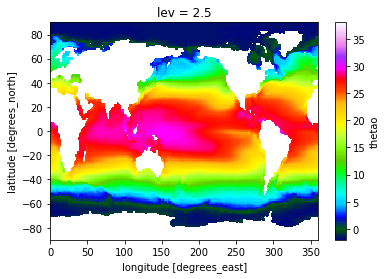

In [11]:
# asking for plot or numerical values will trigger the computation. Time to check out the DASK dashboard
%time temp_mean.sel(lev=2.5).plot(vmin=-2, vmax=38, cmap='gist_ncar')

In [ ]:
# once finished, released the nodes by shutting down the cluster
cluster.close()
client.close()